# Compare distribution of authors pre/post peak
Having determined a slight decrease in context use post-peak (`../../models/run_regression.py` results), we now ask whether this decrease is due to a change in the distribution of authors post-peak to favor more context-light authors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [126]:
import dateutil
from datetime import datetime, timedelta
def round_to_day(x):
    x_day = datetime(day=x.day, month=x.month, year=x.year)
    return x_day
def fix_timezone(x, date_fmt='%Y-%m-%d %H:%M:%S', timezone_str='+0000'):
    # add timezone offset for "naive" dates
    if(x.utcoffset() is None):
        x = datetime.strptime('%s%s'%(x.strftime(date_fmt), timezone_str), '%s%%z'%(date_fmt))
    return x
def assign_peak_date(data, count_var='NE_count', date_var='date_day'):
    max_count = data.loc[:, count_var].max()
    peak_date = data[data.loc[:, count_var] == max_count].loc[:, date_var].iloc[0]
    return peak_date
def load_consistent_data():
    # load full data
    full_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # load anchor data
    anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
    # fix bad usernames
    anchor_data = anchor_data.assign(**{'username' : anchor_data.loc[:, 'username'].apply(lambda x: x.split(':')[-1])})

    date_var = 'date'
    full_data = full_data.assign(**{date_var : full_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    anchor_data = anchor_data.assign(**{date_var : anchor_data.loc[:, date_var].apply(lambda x: fix_timezone(x))})
    ## add time var

    round_date_var = '%s_day'%(date_var)
    full_data = full_data.assign(**{round_date_var : full_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
    anchor_data = anchor_data.assign(**{round_date_var : anchor_data.loc[:, date_var].apply(lambda x: round_to_day(x))})
        ## add NE peak dates
    NE_var = 'NE_fixed'
    round_date_var = 'date_day'
    data_name_var = 'data_name_fixed'
    NE_counts = anchor_data.groupby([NE_var, data_name_var, round_date_var]).apply(lambda x: x.shape[0]).reset_index().rename(columns={0 : 'NE_count'})
    id_var = 'id'
    doc_counts = full_data.groupby([data_name_var, round_date_var]).apply(lambda x: x.loc[:, id_var].nunique()).reset_index().rename(columns={0 : 'doc_count'})
    NE_doc_counts = pd.merge(NE_counts, doc_counts, on=[data_name_var, round_date_var])
    NE_doc_counts = NE_doc_counts.assign(**{'NE_freq' : NE_doc_counts.loc[:, 'NE_count'] / NE_doc_counts.loc[:, 'doc_count']})
    k_consistent = 5
    NE_unique_date_counts = NE_doc_counts.groupby([data_name_var, NE_var]).apply(lambda x: x.loc[:, round_date_var].nunique())
    NE_consistent = NE_unique_date_counts[NE_unique_date_counts >= k_consistent].reset_index().loc[:, [data_name_var, NE_var]]
    NE_doc_counts_consistent = pd.merge(NE_doc_counts, NE_consistent, on=[data_name_var, NE_var], how='inner')

    count_var = 'NE_count'
    NE_count_peaks = NE_doc_counts_consistent.groupby([data_name_var, NE_var]).apply(lambda x: assign_peak_date(x, count_var, date_var=round_date_var)).reset_index().rename(columns={0 : 'peak_date'})
    anchor_data_consistent = pd.merge(anchor_data, NE_count_peaks, on=[NE_var, data_name_var], how='inner')
    peak_date_buffer = timedelta(days=1)
    peak_date_var = 'peak_date'
    round_date_var = 'date_day'
    anchor_data_consistent = anchor_data_consistent.assign(**{
        'pre_peak' : (anchor_data_consistent.loc[:, round_date_var] <= anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer).astype(int),
        'post_peak' : (anchor_data_consistent.loc[:, round_date_var] >= anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer).astype(int),
        'during_peak' : ((anchor_data_consistent.loc[:, round_date_var] > anchor_data_consistent.loc[:, peak_date_var] - peak_date_buffer) & (anchor_data_consistent.loc[:, round_date_var] < anchor_data_consistent.loc[:, peak_date_var] + peak_date_buffer)).astype(int)
    })
    return anchor_data_consistent

In [ ]:
anchor_data_consistent = load_consistent_data()

Let's load the cleaned regression data to make things comparable.

In [ ]:
## update: could not replicate finding from regression (post-peak decrease) with clean regression data...no good
# anchor_data_consistent = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor_NE_peak_times_consistent_authors.gz', sep='\t', compression='gzip', index_col=False)

In [ ]:
## need username+data_name for valid comparison
author_var = 'username'
author_data_var = '%s_%s'%(author_var, data_name_var)
anchor_data_consistent = anchor_data_consistent.assign(**{
     author_data_var : anchor_data_consistent.loc[:, author_var] + '_' + anchor_data_consistent.loc[:, data_name_var]
})

In [ ]:
## only include NEs that occur in all three time periods!!
## otherwise we're comparing apples/oranges
time_vars = ['pre_peak', 'during_peak', 'post_peak']
NE_data_var = '%s_%s'%(NE_var, data_name_var)
anchor_data_consistent = anchor_data_consistent.assign(**{
    NE_data_var : anchor_data_consistent.loc[:, NE_var] + '_' + anchor_data_consistent.loc[:, data_name_var]
})
NE_time_period_counts = anchor_data_consistent.groupby(NE_data_var).apply(lambda x: x.loc[:, time_vars].max(axis=0).sum())
NE_time_period_valid = NE_time_period_counts[NE_time_period_counts == len(time_vars)].index.tolist()
print('%d/%d valid NEs'%(len(NE_time_period_valid), len(NE_time_period_counts)))

In [44]:
anchor_data_consistent_NEs = anchor_data_consistent[anchor_data_consistent.loc[:, NE_data_var].isin(NE_time_period_valid)]

In [43]:
print(anchor_data_consistent.shape[0])
print(anchor_data_consistent_NEs.shape[0])

152243
150062


### Compare pre/post author distribution

In [ ]:
anchor_data_pre_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'pre_peak']==1]
anchor_data_during_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'during_peak']==1]
anchor_data_post_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'post_peak']==1]
pre_peak_authors = anchor_data_pre_peak.loc[:, author_data_var].unique()
during_peak_authors = anchor_data_during_peak.loc[:, author_data_var].unique()
post_peak_authors = anchor_data_post_peak.loc[:, author_data_var].unique()

In [ ]:
time_period_author_joint = set(pre_peak_authors) | set(during_peak_authors) | set(post_peak_authors)
pre_during_joint = set(pre_peak_authors) | set(during_peak_authors)
pre_post_joint = set(pre_peak_authors) | set(post_peak_authors)
during_post_joint = set(during_peak_authors) | set(post_peak_authors)
time_period_author_overlap = set(pre_peak_authors) & set(during_peak_authors) & set(post_peak_authors)
print('%.3f%% of pre-peak authors in pre-peak period'%(len(time_period_author_overlap) / len(pre_peak_authors) * 100))
print('%.3f%% of during-peak authors in during-peak period'%(len(time_period_author_overlap) / len(during_peak_authors) * 100))
print('%.3f%% of post-peak authors in post-peak period'%(len(time_period_author_overlap) / len(post_peak_authors) * 100))

Let's compute the post volume and rate of context use for the following author groups:

- pre-peak (all)
- pre-peak (shared)
- pre-peak (no post-peak)
- post-peak (all)
- post-peak (shared)
- post-peak (no pre-peak)

In [ ]:
pre_peak_only_authors = set(pre_peak_authors) - during_post_joint
during_peak_only_authors = set(during_peak_authors) - pre_post_joint
post_peak_only_authors = set(post_peak_authors) - pre_during_joint

In [ ]:
print('%.2f%% of joint authors in pre-peak only'%(len(pre_peak_only_authors) / len(time_period_author_joint) * 100))
print('%.2f%% of joint authors in during-peak only'%(len(during_peak_only_authors) / len(time_period_author_joint) * 100))
print('%.2f%% of joint authors in post-peak only'%(len(post_peak_only_authors) / len(time_period_author_joint) * 100))

In [ ]:
anchor_data_pre_peak_shared = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_during_peak_shared = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_post_peak_shared = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_pre_peak_pre_only = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(pre_peak_only_authors)]
anchor_data_during_peak_during_only = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(during_peak_only_authors)]
anchor_data_post_peak_post_only = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(post_peak_only_authors)]

In [ ]:
## TODO: compare during and post with pre-peak mean
## compute mean/err
context_var = 'anchor'
author_data_sets = [
    anchor_data_pre_peak, anchor_data_pre_peak_pre_only, anchor_data_pre_peak_shared,
    anchor_data_during_peak, anchor_data_during_peak_during_only, anchor_data_during_peak_shared, 
    anchor_data_post_peak, anchor_data_post_peak_post_only, anchor_data_post_peak_shared, 
]
# per-author, per-NE mean
context_means = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean() for x in author_data_sets]
context_errs = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets]
# per-NE mean
# context_means = [x.groupby(NE_var).apply(lambda x: x.loc[:, context_var].mean()).mean() for x in author_data_sets]
# context_errs = [x.groupby(NE_var).apply(lambda x: x.loc[:, context_var].mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets]
context_mean_overall = anchor_data_consistent_NEs.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean()

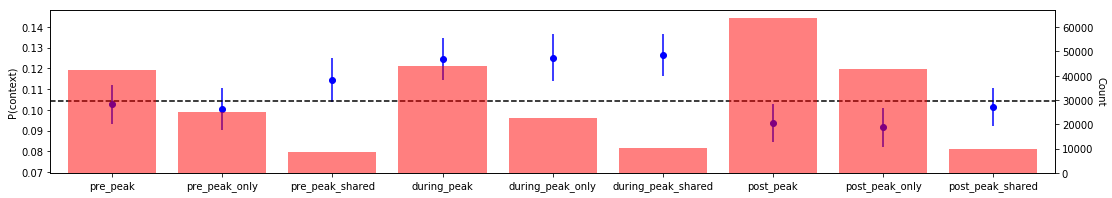

In [42]:
author_data_counts = [x.shape[0] for x in author_data_sets]
author_data_set_names = ['pre_peak', 'pre_peak_only', 'pre_peak_shared',
                         'during_peak', 'during_peak_only', 'during_peak_shared',
                         'post_peak', 'post_peak_only', 'post_peak_shared']
## plot
X = np.arange(len(context_means))
f, ax1 = plt.subplots(figsize=(18,3))
ax2 = ax1.twinx()
ax1.scatter(X, context_means, color='b')
ax1.errorbar(X, context_means, yerr=context_errs, color='b', linestyle='none')
ax1.set_xticks(X)
ax1.set_xticklabels(author_data_set_names)
X_range_pct = 0.07
X_plot_range = [X.min() - X_range_pct*(X.max()-X.min()), X.max() + X_range_pct*(X.max()-X.min())]
ax1.plot(X_plot_range, [context_mean_overall, context_mean_overall], color='k', linestyle='--')
ax2.bar(X, author_data_counts, color='r', alpha=0.5)
ax1.set_ylabel('P(context)')
ax2.set_ylabel('Count', rotation=270, labelpad=12)
plt.xlim(X_plot_range)
plt.show()

- The consistently posting authors (`shared`) have a lower rate of context use, so an increase in context use corresponds with relatively fewer posts from consistent authors.
- Slight decrease in `post_peak` from `during_peak` could be due to relatively fewer posts from `shared` authors. Influx of "non-locals"?

## Compare locations in all author sets

How do we match these results with the results from the regression?

- More location mentions => less context use, which would imply that the `post_peak_shared` authors should have the lowest context use.

We can reconcile the difference if `post_peak_only` authors tend to mention locations more frequently (ex. concentrate on a few important ones) than the `post_peak_shared` authors.

In [80]:
author_var = 'username_data_name_fixed'
NE_var = 'NE_fixed'
post_peak_data_all = [anchor_data_post_peak, anchor_data_post_peak_post_only, anchor_data_post_peak_shared]
post_peak_data_names = ['post_peak', 'post_peak_only', 'post_peak_shared']
for post_peak_data, post_peak_data_name in zip(post_peak_data_all, post_peak_data_names):
    NE_count_per_author = post_peak_data.groupby(author_var).apply(lambda x: x.loc[:, NE_var].nunique())
    post_count_per_author = post_peak_data.groupby(author_var).apply(lambda x: x.shape[0])
    # NE density
    posts_per_NE_per_author = post_peak_data.groupby(author_var).apply(lambda x: x.shape[0] / x.loc[:, NE_var].nunique())
    # log-transform
    print('data=%s, posts=%d, authors=%d'%(post_peak_data_name, post_peak_data.shape[0], post_peak_data.loc[:, author_var].nunique()))
    print('%.3f +/- %.3f NEs per author'%(np.mean(NE_count_per_author), NE_count_per_author.std() / NE_count_per_author.shape[0]**.5))
    print('%.3f +/- %.3f posts per author'%(np.mean(post_count_per_author), post_count_per_author.std() / post_count_per_author.shape[0]**.5))
    print('%.3f +/- %.3f posts/NE'%(np.mean(posts_per_NE_per_author), posts_per_NE_per_author.std() / posts_per_NE_per_author.shape[0]**.5))

data=post_peak, posts=63533, authors=41929
1.206 +/- 0.004 NEs per author
1.515 +/- 0.010 posts per author
1.199 +/- 0.003 posts/NE
data=post_peak_only, posts=42656, authors=33712
1.091 +/- 0.002 NEs per author
1.265 +/- 0.005 posts per author
1.152 +/- 0.003 posts/NE
data=post_peak_shared, posts=9849, authors=2452
2.339 +/- 0.047 NEs per author
4.017 +/- 0.128 posts per author
1.561 +/- 0.023 posts/NE


In [72]:
# restrict to consistent authors
min_author_post_count = 5
for post_peak_data, post_peak_data_name in zip(post_peak_data_all, post_peak_data_names):
    # restrict to consistent authors in each time period??
    author_counts_i = post_peak_data.loc[:, author_var].value_counts()
    consistent_authors_i = author_counts_i[author_counts_i >= min_author_post_count].index.tolist()
    post_peak_data_consistent = post_peak_data[post_peak_data.loc[:, author_var].isin(consistent_authors_i)]
    NE_count_per_author = post_peak_data_consistent.groupby(author_var).apply(lambda x: x.loc[:, NE_var].nunique())
    post_count_per_author = post_peak_data_consistent.groupby(author_var).apply(lambda x: x.shape[0])
    # NE density
    posts_per_NE_per_author = post_peak_data_consistent.groupby(author_var).apply(lambda x: x.shape[0] / x.loc[:, NE_var].nunique())
    # log-transform
    print('data=%s, posts=%d, authors=%d'%(post_peak_data_name, post_peak_data_consistent.shape[0], post_peak_data_consistent.loc[:, author_var].nunique()))
    print('%.3f +/- %.3f NEs per author'%(np.mean(NE_count_per_author), NE_count_per_author.std() / NE_count_per_author.shape[0]**.5))
    print('%.3f +/- %.3f posts per author'%(np.mean(post_count_per_author), post_count_per_author.std() / post_count_per_author.shape[0]**.5))
    print('%.3f +/- %.3f posts/NE'%(np.mean(posts_per_NE_per_author), posts_per_NE_per_author.std() / posts_per_NE_per_author.shape[0]**.5))

data=post_peak, posts=11874, authors=1334
3.779 +/- 0.081 NEs per author
8.901 +/- 0.205 posts per author
3.092 +/- 0.061 posts/NE
data=post_peak_only, posts=2427, authors=362
2.365 +/- 0.078 NEs per author
6.704 +/- 0.139 posts per author
3.976 +/- 0.141 posts/NE
data=post_peak_shared, posts=6339, authors=572
4.955 +/- 0.148 NEs per author
11.082 +/- 0.425 posts per author
2.587 +/- 0.077 posts/NE


Conclusion: we expected `post_peak_only` authors to have more posts per NE (which means more chance of context use decrease) but in fact the `post_peak_shared` authors have slightly more posts per NE.

However! When we restrict to consistent authors ($k>=5$ posts each) we see more concentration of posts per NE -> the overall decrease is driven by the consistent authors.

What do the overall distributions of posts/NE look like?

In [73]:
posts_per_NE_per_author_list = []
for post_peak_data, post_peak_data_name in zip(post_peak_data_all, post_peak_data_names):
    # NE density
    posts_per_NE_per_author = post_peak_data.groupby(author_var).apply(lambda x: x.shape[0] / x.loc[:, NE_var].nunique())
    # log-transform
    print('data=%s, posts=%d, authors=%d'%(post_peak_data_name, post_peak_data.shape[0], post_peak_data.loc[:, author_var].nunique()))
    posts_per_NE_per_author_list.append(posts_per_NE_per_author)

data=post_peak, posts=63533, authors=41929
data=post_peak_only, posts=42656, authors=33712
data=post_peak_shared, posts=9849, authors=2452


In [ ]:
# plot the distributions

In [79]:
from scipy.stats import wilcoxon, kruskal, mannwhitneyu
for i in range(len(posts_per_NE_per_author_list)):
    for j in range(i+1, len(posts_per_NE_per_author_list)):
        print('%s vs. %s'%(post_peak_data_names[i], post_peak_data_names[j]))
#         test_stat, p_val = kruskal(posts_per_NE_per_author_list[i], posts_per_NE_per_author_list[j])
        test_stat, p_val = mannwhitneyu(posts_per_NE_per_author_list[i], posts_per_NE_per_author_list[j], alternative='less')
        print('distribution difference test: test stat = %.3f, p = %.3E'%(test_stat, p_val))

post_peak vs. post_peak_only
distribution difference test: test stat = 729994578.000, p = 1.000E+00
post_peak vs. post_peak_shared
distribution difference test: test stat = 38126449.000, p = 3.737E-260
post_peak_only vs. post_peak_shared
distribution difference test: test stat = 29284833.500, p = 0.000E+00


TODO: plot overlapping distributions of posts/NE for all author categories

### Test differences in control variable distributions between post-peak-only and post-peak-shared
Based on the regression, the following control variables are correlated with lower context use:

- post length
- URL

Let's test each of these.

In [64]:
import re
from data_helpers import compute_post_length
# process data
url_matcher = re.compile('<URL>')
txt_var = 'txt'
anchor_data_consistent_NEs = anchor_data_consistent_NEs.assign(**{'has_URL' : anchor_data_consistent_NEs.loc[:, txt_var].apply(lambda x: int(url_matcher.search(x) is not None))})

## add character length of post without context
post_len_bins = 11
anchor_data_consistent_NEs = compute_post_length(anchor_data_consistent_NEs, bins=post_len_bins)

In [68]:
## re-segment datasets
anchor_data_pre_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'pre_peak']==1]
anchor_data_during_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'during_peak']==1]
anchor_data_post_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'post_peak']==1]
pre_peak_authors = anchor_data_pre_peak.loc[:, author_data_var].unique()
during_peak_authors = anchor_data_during_peak.loc[:, author_data_var].unique()
post_peak_authors = anchor_data_post_peak.loc[:, author_data_var].unique()
anchor_data_pre_peak_shared = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_during_peak_shared = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_post_peak_shared = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_pre_peak_pre_only = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(pre_peak_only_authors)]
anchor_data_during_peak_during_only = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(during_peak_only_authors)]
anchor_data_post_peak_post_only = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(post_peak_only_authors)]

In [69]:
author_var = 'username_data_name_fixed'
NE_var = 'NE_fixed'
post_peak_data_all = [anchor_data_post_peak, anchor_data_post_peak_post_only, anchor_data_post_peak_shared]
post_peak_data_names = ['post_peak', 'post_peak_only', 'post_peak_shared']
control_vars = ['has_URL', 'txt_len_norm']
for control_var in control_vars:
    for data_i, data_name_i in zip(post_peak_data_all, post_peak_data_names):
        var_per_author = data_i.groupby(author_var).apply(lambda x: x.loc[:, control_var].mean())
        print('data=%s, posts=%d, authors=%d'%(data_name_i, data_i.shape[0], data_i.loc[:, author_var].nunique()))
        print('var=%s, mean=%.3f +/- %.3f'%(control_var, np.mean(var_per_author), var_per_author.std() / var_per_author.shape[0]**.5))

data=post_peak, posts=63533, authors=41929
var=has_URL, mean=0.647 +/- 0.002
data=post_peak_only, posts=42656, authors=33712
var=has_URL, mean=0.635 +/- 0.003
data=post_peak_shared, posts=9849, authors=2452
var=has_URL, mean=0.740 +/- 0.008
data=post_peak, posts=63533, authors=41929
var=txt_len_norm, mean=0.578 +/- 0.001
data=post_peak_only, posts=42656, authors=33712
var=txt_len_norm, mean=0.577 +/- 0.001
data=post_peak_shared, posts=9849, authors=2452
var=txt_len_norm, mean=0.577 +/- 0.003


The `has_URL` results are backward: the `post_peak_only` authors should have higher rate of URLs to correlate with lower context use.

### Author set comparison

Who are the authors in the `post_peak_only` group, and how are they different from the authors in `pre_peak_only` and `during_peak_only`?

In [38]:
author_var = 'username'
data_name_var = 'data_name_fixed'
data_names = anchor_data_consistent_NEs.loc[:, data_name_var].unique()
author_data_var = '%s_%s'%(author_var, data_name_var)
top_k = 10
for name_i in data_names:
    print('processing data %s'%(name_i))
    pre_peak_i = anchor_data_pre_peak_pre_only[anchor_data_pre_peak_pre_only.loc[:, data_name_var]==name_i]
    during_peak_i = anchor_data_during_peak_during_only[anchor_data_during_peak_during_only.loc[:, data_name_var]==name_i]
    post_peak_i = anchor_data_post_peak_post_only[anchor_data_post_peak_post_only.loc[:, data_name_var]==name_i]
    author_counts_pre_peak_i = pre_peak_i.loc[:, author_var].value_counts()
    author_counts_during_peak_i = during_peak_i.loc[:, author_var].value_counts()
    author_counts_post_peak_i = post_peak_i.loc[:, author_var].value_counts()
    print('top-%d pre-peak authors:\n%s'%(top_k, author_counts_pre_peak_i.head(top_k)))
    print('top-%d during-peak authors:\n%s'%(top_k, author_counts_during_peak_i.head(top_k)))
    print('top-%d post-peak authors:\n%s'%(top_k, author_counts_post_peak_i.head(top_k)))

processing data harvey
top-10 pre-peak authors:
joshuatcarley      11
CuteBlessedBarb     6
tbhlifesuckslol     6
TylerWeather9       6
PGGargleblaster     5
MRMacDaddy2U        5
ghosth0e            5
TeachCorbett        5
squonk_CDN          5
BrentSullivan       5
Name: username, dtype: int64
top-10 during-peak authors:
FarrahFazal       10
Grtitude           9
DDeBane            9
severestudios      9
BlackBeardRyan     8
TommySledge        8
daymonjones        8
imy26sky           8
jnelsonWJCL        7
ElyteFaeva         7
Name: username, dtype: int64
top-10 post-peak authors:
toddgillman        25
JB3819             20
EcoInternetDrGB    20
attadog9           17
sculptorwriter     17
shannonrwatts      16
HoustoniaMag       14
lovinghouston      14
WoFat              14
VMVideos_com       14
Name: username, dtype: int64
processing data irma
top-10 pre-peak authors:
CodyMicahC        48
LeshaTweets       25
ch1election       15
jadaschiessl      14
meooh22           14
MiamiBeach

Across the datasets we don't see a consistent difference between the top-k authors in the `post_peak` and `pre_peak`/`during_peak` sets.
- `florence`
    - `post_peak` has more local media accounts (`StarNewsOnline`, `NCPorts`, `NC_Culture`)
- `harvey`
    - `post_peak` has more local media accounts (`HoustoniaMag`, `lovinghouston`)
- `irma`
    - `pre_peak` and `during_peak` have more weather accounts (`Track_Irma`, `Jointcyclone`, `PIXweather`)
- `maria`
    - `post_peak` has more local media accounts (`UnivisionPR`, `FEMAPortavoz`); `pre_peak` has more weather accounts (`altNOAA`, `StormVids`, `PRseprepara`)
- `michael`
    - `post_peak` has more media accounts (`FoxNewsResearch`, `KelsieMetzgarTV`)

### Use author metadata to find population change
We've collected author metadata [here](mine_user_data_from_twitter_archive.py), so let's see if we can find consistent changes in the population pre/post peak.

In [2]:
import numpy as np
import pandas as pd
import dateutil
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [39]:
user_data = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
user_data.fillna('', inplace=True)
print(user_data.shape[0])
display(user_data.head())
author_var = 'username'
data_name_var = 'data_name_fixed'
date_var = 'date'
user_meta_vars = ['location', 'description', 'followers_count', 'friends_count', 'created_at']
user_data.sort_values([author_var, date_var], inplace=True, ascending=True)
user_dedup = user_data.drop_duplicates([author_var, data_name_var]).loc[:, user_meta_vars + [author_var, data_name_var]]
print(user_dedup.shape[0])

310514


,location,description,followers_count,friends_count,statuses_count,created_at,date,data_name_fixed,username
0,barcelona,"Xavier Mitjavila Moix de París, Francia y Barc...",163,43,18485,Tue Jul 31 19:38:02 +0000 2018,2018-09-03,florence,xaviermitjavila
1,"New York, USA",Google Expert #DigitalMarketing #SEO #SEM #Soc...,602,399,131224,Thu Jun 18 14:30:14 +0000 2009,2018-09-03,florence,muhemmedasfand
2,"Dublin City, Ireland","Forecaster for http://Metcast.net, senior mode...",992,1140,20599,Wed Aug 01 14:52:44 +0000 2012,2018-09-03,florence,bruensryan
3,I Block Trolls USA,This is a PC FREE Zone! There is a possibility...,2637,2975,58774,Mon Jan 19 18:38:04 +0000 2009,2018-09-03,florence,fancygap1
4,"Fort Lauderdale, Florida",Former AM radio talk show host @AM740WSBR @AM1...,12458,10385,274683,Wed Apr 08 16:24:57 +0000 2009,2018-09-03,florence,4billlewis


57071


In [77]:
user_data_locs = user_data.loc[:, 'location'].apply(lambda x: x.lower()).value_counts()
display(user_data_locs.head(50))

                       52453
united states           7110
houston, tx             5392
usa                     3844
washington, dc          3241
florida, usa            3005
texas, usa              2698
miami, fl               2292
new york, ny            2268
atlanta, ga             2252
austin, tx              2050
texas                   1995
los angeles, ca         1683
orlando, fl             1671
california, usa         1549
florida                 1341
dallas, tx              1323
tampa, fl               1075
houston, texas           981
charlotte, nc            965
los angeles              948
worldwide                945
puerto rico              936
new york, usa            934
boston, ma               931
new york                 916
san antonio, tx          855
chicago, il              851
new york city            836
houston                  820
earth                    803
canada                   795
austin, texas            784
nyc                      783
washington, d.

Locations mostly make sense! Affected regions are most popular (FL and TX).

Let's check data coverage.

In [46]:
anchor_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor_NE_peak_times_consistent_authors.gz', sep='\t', index_col=False, compression='gzip', converters={'date_day' : dateutil.parser.parse})
author_var = 'username'
date_var = 'date'
round_date_var = 'date_day'
anchor_data = anchor_data.assign(**{
    author_var : anchor_data.loc[:, author_var].apply(lambda x: x.lower())
})
anchor_data = anchor_data.drop(date_var, axis=1, inplace=False).rename(columns={round_date_var : date_var}, inplace=False)
print(anchor_data.shape[0])

149565


In [47]:
shared_authors = set(anchor_data.loc[:, author_var].unique()) & set(user_data.loc[:, author_var].unique())
print('%d shared authors'%(len(shared_authors)))

3325 shared authors


Let's look at the shared author stats.

In [48]:
user_data_shared = user_dedup[user_dedup.loc[:, author_var].isin(shared_authors)]
display(user_data_shared.loc[:, data_name_var].value_counts())

harvey      2145
irma        2104
michael      445
florence     399
maria        369
Name: data_name_fixed, dtype: int64

### Identify locals

First pass: identify locals based on state name.

Let's use a hack to find locals: if location has affected state, count author as local.

In [79]:
import re
from data_helpers import DATA_NAME_STATES_LOOKUP
DATA_NAME_STATES_MATCHER = {
    k : re.compile('|'.join(['(?<=[, ])%s$|^%s,\s+'%((loc.lower(),)*2) for loc in v]))
    for k,v in DATA_NAME_STATES_LOOKUP.items()
}
print(DATA_NAME_STATES_MATCHER['florence'].pattern)

(?<=[, ])fl$|^fl,\s+|(?<=[, ])nc$|^nc,\s+|(?<=[, ])sc$|^sc,\s+|(?<=[, ])va$|^va,\s+|(?<=[, ])ga$|^ga,\s+|(?<=[, ])florida$|^florida,\s+|(?<=[, ])north carolina$|^north carolina,\s+|(?<=[, ])south carolina$|^south carolina,\s+|(?<=[, ])virginia$|^virginia,\s+|(?<=[, ])georgia$|^georgia,\s+


In [207]:
loc_var = 'location'
state_local_var = 'is_state_local'
user_dedup = user_dedup.assign(**{
    state_local_var : user_dedup.apply(lambda x: DATA_NAME_STATES_MATCHER[x.loc[data_name_var]].search(x.loc[loc_var].lower()) is not None, axis=1)
})

Second pass: for all non-state locations, find all locals according to the same criteria that we used to identify valid locations:

- $L$ matches a location within geo bounds
- $L$ is unambiguous within geo bounds

In [202]:
def is_local(location, data_name, gazetteers):
    gazetteer = gazetteers[data_name]
#     location_local = (location in gazetteer) and (gazetteer[location].shape[0] <= 1)
    location_local = location in gazetteer
    return location_local

In [171]:
## load gazetteer
import pickle
geonames_dict = pickle.load(open('/hg190/corpora/GeoNames/allCountriesSimplified_lookup_US.pickle', 'rb'))

In [ ]:
## separate by data region
from collect_validate_NEs_in_tweets import DATA_LOC_BOXES
## TODO: vectorize containment
def contains(coord, box):
    return coord[0] >= box[0][0] and coord[0] <= box[0][1] and coord[1] >= box[1][0] and coord[1] <= box[1][1]
lat_var = 'latitude'
lon_var = 'longitude'
gazetteers = {
    data_name : {k : v[v.loc[:, [lat_var, lon_var]].apply(lambda x: contains(x, data_loc_box), axis=1)] for k,v in geonames_dict.items()}
    for data_name, data_loc_box in DATA_LOC_BOXES.items()
}
# get rid of empty entries
gazetteers = {
    data_name : {k : v for k,v in gazetteer.items() if v.shape[0] > 0}
    for data_name, gazetteer in gazetteers.items()
}

In [191]:
## deduplicate copy locations
def dedup_locations(data, importance_var='population', coord_cols=['latitude', 'longitude'], round_place=1):
    data = data.assign(**{
        '%s_norm'%(coord_col) : (data.loc[:, coord_col] / round_place).astype(int)
        for coord_col in coord_cols
    })
    data.sort_values(importance_var, inplace=True, ascending=False)
    norm_coord_cols = ['%s_norm'%(coord_col) for coord_col in coord_cols]
    data.drop_duplicates(norm_coord_cols, inplace=True, keep='first')
    return data

In [193]:
gazetteers_dedup = {
    data_name : {k : dedup_locations(v) for k,v in gazetteer.items()}
    for data_name, gazetteer in gazetteers.items()
}

Now that we have the deduplicated locations, let's assign local/non-local status to all authors with no state location.

In [204]:
assert is_local('san juan', 'maria', gazetteers_dedup)
assert is_local('houston', 'harvey', gazetteers_dedup)
assert not is_local('san juan', 'irma', gazetteers_dedup)

In [216]:
from unidecode import unidecode
data_name_var = 'data_name_fixed'
loc_var = 'location'
city_local_var = 'is_city_local'
user_dedup = user_dedup.assign(**{
    city_local_var : user_dedup.apply(lambda x: is_local(unidecode(x.loc[loc_var].lower()), x.loc[data_name_var], gazetteers_dedup), axis=1)
})

In [217]:
# combine state/city
local_var = 'is_local'
user_dedup = user_dedup.assign(**{
    local_var : user_dedup.loc[:, [state_local_var, city_local_var]].max(axis=1)
})

In [218]:
# how many locals per dataset
display(user_dedup.groupby(data_name_var).apply(lambda x: x.loc[:, state_local_var].sum()))
display(user_dedup.groupby(data_name_var).apply(lambda x: x.loc[:, city_local_var].sum()))
display(user_dedup.groupby(data_name_var).apply(lambda x: x.loc[:, local_var].sum()))

data_name_fixed
florence     848
harvey      5502
irma        4157
maria        161
michael      436
dtype: int64

data_name_fixed
florence     101
harvey      6201
irma        1053
maria        135
michael       99
dtype: int64

data_name_fixed
florence      949
harvey      11703
irma         5210
maria         294
michael       534
dtype: int64

We should also bin users by their follower/following count as a rough estimate of popularity.

In [219]:
N_bins = 10
follower_var = 'followers_count'
log_follower_var = 'log_%s'%(follower_var)
# following_var = 'friends_count'
user_dedup = user_dedup.assign(**{
     log_follower_var : np.log(user_dedup.loc[:, follower_var]+1)
})
follower_bins = np.linspace(user_dedup.loc[:, log_follower_var].min(), user_dedup.loc[:, log_follower_var].max(), num=N_bins)
follower_bin_var = '%s_bin'%(log_follower_var)
user_dedup = user_dedup.assign(**{
    follower_bin_var : np.digitize(user_dedup.loc[:, log_follower_var], follower_bins)
})

Let's add these to the context data and look for differentiation in the author groups.

In [220]:
author_var = 'username'
data_name_var = 'data_name_fixed'
round_date_var = 'date_day'
date_var = 'date'
anchor_data_user_data = pd.merge(anchor_data, user_dedup, on=[author_var, data_name_var], how='inner')
print('%d/%d data'%(anchor_data_user_data.shape[0], anchor_data.shape[0]))
print('%d/%d/%d pre/during/post'%
      (anchor_data_user_data.loc[:, 'pre_peak'].sum(), anchor_data_user_data.loc[:, 'during_peak'].sum(), anchor_data_user_data.loc[:, 'post_peak'].sum()))

28079/149565 data
7440/9263/11376 pre/during/post


What is the distribution of the following attributes for the different time periods:

- `is_local`
- `follower_bin`

Add variable for dataset-specific NEs.

In [221]:
NE_var = 'NE_fixed'
NE_data_var = 'NE_data_name'
anchor_data_user_data = anchor_data_user_data.assign(**{
    NE_data_var : anchor_data_user_data.loc[:, NE_var] + '_' + anchor_data_user_data.loc[:, data_name_var]
})

In [222]:
anchor_user_dedup = anchor_data_user_data.drop_duplicates([author_var, data_name_var], inplace=False)

In [223]:
peak_data_dedup_list = [
    anchor_user_dedup[anchor_user_dedup.loc[:, 'pre_peak']==1],
    anchor_user_dedup[anchor_user_dedup.loc[:, 'during_peak']==1],
    anchor_user_dedup[anchor_user_dedup.loc[:, 'post_peak']==1],
]
peak_data_list = [
    anchor_data_user_data[anchor_data_user_data.loc[:, 'pre_peak']==1],
    anchor_data_user_data[anchor_data_user_data.loc[:, 'during_peak']==1],
    anchor_data_user_data[anchor_data_user_data.loc[:, 'post_peak']==1],
]
local_pct_means = [x.loc[:, local_var].mean() for x in peak_data_dedup_list]
follower_means = [x.loc[:, log_follower_var].mean() for x in peak_data_dedup_list]
local_pct_errs = [x.loc[:, local_var].std() / x.shape[0]**.5 for x in peak_data_dedup_list]
follower_errs = [x.loc[:, log_follower_var].std() / x.shape[0]**.5 for x in peak_data_dedup_list]

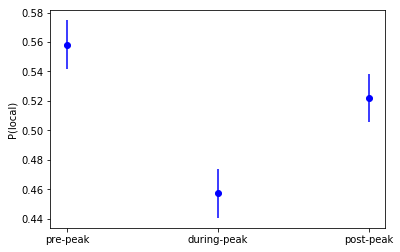

In [224]:
X = np.arange(len(peak_data_list))
X_str = ['pre-peak', 'during-peak', 'post-peak']
# local
plt.scatter(X, local_pct_means, color='b')
plt.errorbar(X, local_pct_means, yerr=local_pct_errs, color='b', linestyle='none')
plt.xticks(X, X_str)
plt.ylabel('P(local)')
plt.show()

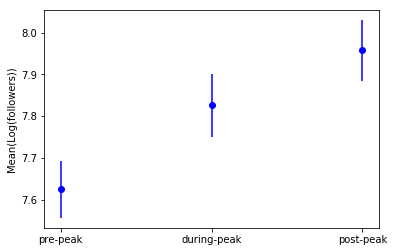

In [225]:
# follower
plt.scatter(X, follower_means, color='b')
plt.errorbar(X, follower_means, yerr=follower_errs, color='b', linestyle='none')
plt.xticks(X, X_str)
plt.ylabel('Mean(Log(followers))')
plt.show()

OK! We see more locals pre-peak and post-peak, and we see more popular accounts over time.

Do these groups have different levels of context use?

We need base rate of context use first.

In [226]:
def compute_context_means(data, author_var='username', NE_data_var='NE_data_name', context_var='anchor'):
    context_means = data.groupby(author_var).apply(lambda x: x.groupby(NE_data_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
    return context_means

In [227]:
context_means = [x.groupby(author_var).apply(lambda x: x.groupby(NE_data_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean() for x in peak_data_list]
context_errs = [x.groupby(author_var).apply(lambda x: x.groupby(NE_data_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).std() / x.drop_duplicates([author_var, NE_data_var]).shape[0]**.5 for x in peak_data_list]

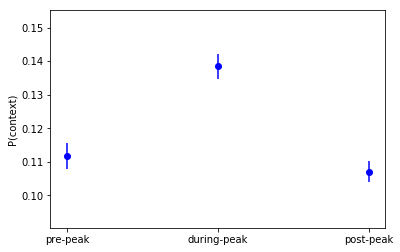

In [228]:
plt.scatter(X, context_means, color='b')
plt.errorbar(X, context_means, yerr=context_errs, color='b', linestyle='none')
plt.xticks(X, X_str)
plt.ylabel('P(context)')
plt.show()

### Compare context use in locals vs. non-locals

In [229]:
local_context_means = [compute_context_means(x[x.loc[:, local_var]==1]).mean() for x in peak_data_list]
non_local_context_means = [compute_context_means(x[x.loc[:, local_var]==0]).mean() for x in peak_data_list]
local_context_errs = [compute_context_means(x[x.loc[:, local_var]==1]).std() / x[x.loc[:, local_var]==1].drop_duplicates([NE_data_var, author_var]).shape[0]**.5 for x in peak_data_list]
non_local_context_errs = [compute_context_means(x[x.loc[:, local_var]==0]).std() / x[x.loc[:, local_var]==0].drop_duplicates([NE_data_var, author_var]).shape[0]**.5 for x in peak_data_list]
# local_context_means = [x[x.loc[:, local_var]==1].groupby(NE_data_var).apply(lambda x: x.loc[:, context_var].mean()).mean() for x in peak_data_list]
# non_local_context_means = [x[x.loc[:, local_var]==0].groupby(NE_data_var).apply(lambda x: x.loc[:, context_var].mean()).mean() for x in peak_data_list]
# local_context_errs = [x[x.loc[:, local_var]==1].groupby(NE_data_var).apply(lambda x: x.loc[:, context_var].mean()).std() / x[x.loc[:, local_var]==1].loc[:, NE_data_var].nunique()**.5 for x in peak_data_list]
# non_local_context_errs = [x[x.loc[:, local_var]==0].groupby(NE_data_var).apply(lambda x: x.loc[:, context_var].mean()).std() / x[x.loc[:, local_var]==0].loc[:, NE_data_var].nunique()**.5 for x in peak_data_list]

In [230]:
# proportions of posts written by local/non-local authors
peak_data_list_dedup = [x.drop_duplicates([author_var, data_name_var]) for x in peak_data_list]
local_pcts = [x.loc[:, local_var].sum() / x.shape[0] for x in peak_data_list]
non_local_pcts = [1 - (x.loc[:, local_var].sum() / x.shape[0]) for x in peak_data_list]

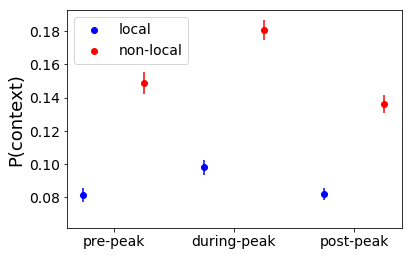

In [234]:
# local context use
X_offset = 0.25
f, ax1 = plt.subplots(figsize=(6, 4))
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.scatter(X-X_offset, local_context_means, color='b', label='local')
ax1.errorbar(X-X_offset, local_context_means, yerr=local_context_errs, color='b', linestyle='none')
ax1.scatter(X+X_offset, non_local_context_means, color='r', label='non-local')
ax1.errorbar(X+X_offset, non_local_context_means, yerr=non_local_context_errs, color='r', linestyle='none')
ax1.legend(loc='upper left', fontsize=14)
ax1.set_ylabel('P(context)', fontsize=18)
ax1.set_xticks(X)
ax1.set_xticklabels(X_str)
## proportions
# ax2 = ax1.twinx()
# ax2.bar(X-X_offset, local_pcts, width=0.1, color='b', alpha=0.3)
# ax2.bar(X+X_offset, non_local_pcts, width=0.1, color='r', alpha=0.3)
# ax2.set_ylabel('Proportion of posts', rotation=270, labelpad=18)
plt.show()

Non-locals use more context (duh), and the difference is bigger post-peak.

Let's do significance testing to make sure the differences are legit.

In [95]:
from scipy.stats import ttest_ind
for i in range(len(peak_data_list)):
    data_i = peak_data_list[i]
    local_context_means_i = compute_context_means(data_i[data_i.loc[:, local_var]==1])
    non_local_context_means_i = compute_context_means(data_i[data_i.loc[:, local_var]==0])
    mean_diff_i = local_context_means_i.mean() - non_local_context_means_i.mean()
    test_stat, p_val = ttest_ind(local_context_means_i, non_local_context_means_i)
    print('mean diff %.3f is significant with test_stat=%.3f (p=%.3E)'%(mean_diff_i, test_stat, p_val))

mean diff -0.052 is significant with test_stat=-5.105 (p=3.561E-07)
mean diff -0.086 is significant with test_stat=-8.341 (p=1.166E-16)
mean diff -0.062 is significant with test_stat=-6.503 (p=9.384E-11)


### Compare context use in high vs. low followers

In [62]:
follower_median = anchor_user_dedup.loc[:, log_follower_var].median()
high_follower_context_means = [compute_context_means(x[x.loc[:, log_follower_var] >= follower_median]).mean() for x in peak_data_list]
low_follower_context_means = [compute_context_means(x[x.loc[:, log_follower_var] < follower_median]).mean() for x in peak_data_list]
high_follower_context_errs = [compute_context_means(x[x.loc[:, log_follower_var] >= follower_median]).std() / x[x.loc[:, log_follower_var] >= follower_median].drop_duplicates([author_var, NE_data_var]).shape[0]**.5 for x in peak_data_list]
low_follower_context_errs = [compute_context_means(x[x.loc[:, log_follower_var] < follower_median]).std() / x[x.loc[:, log_follower_var] < follower_median].drop_duplicates([author_var, NE_data_var]).shape[0]**.5 for x in peak_data_list]

In [63]:
# proportions of posts written by high/low-follower authors
high_follower_pcts = [x[x.loc[:, log_follower_var] >= follower_median].shape[0] / x.shape[0] for x in peak_data_list]
low_follower_pcts = [x[x.loc[:, log_follower_var] < follower_median].shape[0] / x.shape[0] for x in peak_data_list]

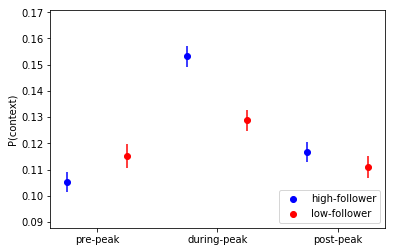

In [65]:
# followers
X_offset = 0.25
f, ax1 = plt.subplots(figsize=(6, 4))
ax1.scatter(X-X_offset, high_follower_context_means, color='b', label='high-follower')
ax1.errorbar(X-X_offset, high_follower_context_means, yerr=high_follower_context_errs, color='b', linestyle='none')
ax1.scatter(X+X_offset, low_follower_context_means, color='r', label='low-follower')
ax1.errorbar(X+X_offset, low_follower_context_means, yerr=low_follower_context_errs, color='r', linestyle='none')
ax1.legend(loc='lower right')
ax1.set_ylabel('P(context)')
ax1.set_xticks(X)
ax1.set_xticklabels(X_str)
## proportions
# ax2 = ax1.twinx()
# ax2.bar(X-X_offset, high_follower_pcts, width=0.1, color='b', alpha=0.3)
# ax2.bar(X+X_offset, low_follower_pcts, width=0.1, color='r', alpha=0.3)
# ax2.set_ylabel('Proportion of posts', rotation=270, labelpad=18)
plt.show()

High followers use more context than low followers in `during_peak` and `post_peak`, because more likely to need to provide context to audience.

So why is it the case that post-peak shows an overall decrease in context use if the author base is changing?? We have to assume that more locals in post-peak => lower need for context overall.

### Overlap between time-period-only authors and local authors
Let's see if the authors who are specific to a time period are more often locals.

In [109]:
anchor_data_pre_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'pre_peak']==1]
anchor_data_during_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'during_peak']==1]
anchor_data_post_peak = anchor_data_consistent_NEs[anchor_data_consistent_NEs.loc[:, 'post_peak']==1]
pre_peak_authors = anchor_data_pre_peak.loc[:, author_data_var].unique()
during_peak_authors = anchor_data_during_peak.loc[:, author_data_var].unique()
post_peak_authors = anchor_data_post_peak.loc[:, author_data_var].unique()
time_period_author_joint = set(pre_peak_authors) | set(during_peak_authors) | set(post_peak_authors)
pre_during_joint = set(pre_peak_authors) | set(during_peak_authors)
pre_post_joint = set(pre_peak_authors) | set(post_peak_authors)
during_post_joint = set(during_peak_authors) | set(post_peak_authors)
time_period_author_overlap = set(pre_peak_authors) & set(during_peak_authors) & set(post_peak_authors)
print('%.3f%% of pre-peak authors in pre-peak period'%(len(time_period_author_overlap) / len(pre_peak_authors) * 100))
print('%.3f%% of during-peak authors in during-peak period'%(len(time_period_author_overlap) / len(during_peak_authors) * 100))
print('%.3f%% of post-peak authors in post-peak period'%(len(time_period_author_overlap) / len(post_peak_authors) * 100))
pre_peak_only_authors = set(pre_peak_authors) - during_post_joint
during_peak_only_authors = set(during_peak_authors) - pre_post_joint
post_peak_only_authors = set(post_peak_authors) - pre_during_joint
anchor_data_pre_peak_shared = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_during_peak_shared = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_post_peak_shared = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(time_period_author_overlap)]
anchor_data_pre_peak_pre_only = anchor_data_pre_peak[anchor_data_pre_peak.loc[:, author_data_var].isin(pre_peak_only_authors)]
anchor_data_during_peak_during_only = anchor_data_during_peak[anchor_data_during_peak.loc[:, author_data_var].isin(during_peak_only_authors)]
anchor_data_post_peak_post_only = anchor_data_post_peak[anchor_data_post_peak.loc[:, author_data_var].isin(post_peak_only_authors)]
## TODO: compare during and post with pre-peak mean
## compute mean/err
context_var = 'anchor'
author_data_sets = [
    anchor_data_pre_peak, anchor_data_pre_peak_pre_only, anchor_data_pre_peak_shared,
    anchor_data_during_peak, anchor_data_during_peak_during_only, anchor_data_during_peak_shared, 
    anchor_data_post_peak, anchor_data_post_peak_post_only, anchor_data_post_peak_shared, 
]
author_data_set_names = ['pre_peak', 'pre_peak_only', 'pre_peak_shared',
                         'during_peak', 'during_peak_only', 'during_peak_shared',
                         'post_peak', 'post_peak_only', 'post_peak_shared']
# per-author, per-NE mean
context_means = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean() for x in author_data_sets]
context_errs = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets]
# per-NE mean
# context_means = [x.groupby(NE_var).apply(lambda x: x.loc[:, context_var].mean()).mean() for x in author_data_sets]
# context_errs = [x.groupby(NE_var).apply(lambda x: x.loc[:, context_var].mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets]
context_mean_overall = anchor_data_consistent_NEs.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean()

8.960% of pre-peak authors in pre-peak period
9.054% of during-peak authors in during-peak period
5.834% of post-peak authors in post-peak period


In [103]:
author_var = 'username'
data_name_var = 'data_name_fixed'
local_var = 'is_local'
author_data_sets = [pd.merge(x, user_dedup.loc[:, [author_var, data_name_var, local_var]], on=[author_var, data_name_var], how='inner') for x in author_data_sets]
author_data_sets_local = [x[x.loc[:, local_var]==1] for x in author_data_sets]
author_data_sets_non_local = [x[x.loc[:, local_var]==0] for x in author_data_sets]

In [107]:
local_context_means = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean() for x in author_data_sets_local]
non_local_context_means = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).mean() for x in author_data_sets_non_local]
local_context_errs = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets_local]
non_local_context_errs = [x.groupby(author_data_var).apply(lambda x: x.groupby(NE_var).apply(lambda y: y.loc[:, context_var].mean()).mean()).std() / (x.loc[:, NE_var].nunique()**.5) for x in author_data_sets_non_local]

In [111]:
all_context_means = pd.DataFrame([local_context_means, non_local_context_means], columns=author_data_set_names, index=['local', 'non-local'])
display(all_context_means)

,pre_peak,pre_peak_only,pre_peak_shared,during_peak,during_peak_only,during_peak_shared,post_peak,post_peak_only,post_peak_shared
local,0.105271,0.104446,0.101242,0.109490,0.113095,0.096068,0.088336,0.092066,0.079274
non-local,0.112823,0.109760,0.134807,0.130226,0.130566,0.154753,0.093763,0.088499,0.147098


Not great! We see here that the post-peak-only local authors have a higher rate of context use as compared to the non-locals. This suggests that we need a representative sample.

### Test population change with metadata: organization vs. individual
We've determined that many of the authors are official organizations (ex. disaster relief, government, nonprofits) and that these authors can be identified based on metadata ([here](scripts/data_processing/classify_authors_by_metadata.ipynb)). 

Let's classify all the authors available with metadata and test organization/non-organization as a potential population change effect.

In [112]:
import pandas as pd

In [87]:
# user data from archives
# user_data = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data_archive.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
# user data from Twitter (recently mined => less accurate but higher coverage)
user_data = pd.read_csv('../../data/mined_tweets/tweet_user_data/user_data_twitter_mine.gz', sep='\t', index_col=False, converters={'created_at' : dateutil.parser.parse, 'date' : dateutil.parser.parse})
user_data.fillna('', inplace=True)
print(user_data.shape[0])
display(user_data.head())
author_var = 'username'
date_var = 'date'
user_meta_vars = ['location', 'description', 'friends_count', 'followers_count', 'created_at', 'statuses_count', 'name', 'verified']
user_data.sort_values([author_var, date_var], inplace=True, ascending=True)
user_dedup = user_data.drop_duplicates(author_var).loc[:, user_meta_vars + [author_var]]
print(user_dedup.shape[0])

71872


,name,id,location,description,followers_count,friends_count,statuses_count,created_at,verified,listed_count,username,date
0,wralweather,15923563,"Raleigh, NC",NC's most trusted source for weather. WRAL's 6...,175728,950,27307,2008-08-20 21:29:21,True,665,wralweather,2019-08-26
1,Neil Ackerman,328209091,"East Meadow, NY (516-425-5365)",#Attorney (Rated 5.0 #AV in Martindale-Hubbell...,11517,8385,104227,2011-07-02 23:16:23,False,877,acklaw,2019-08-26
2,FoodPages.ca,139342722,Canada,The Guide to Canada's Restaurants and Food Stores,3822,488,209481,2010-05-02 09:08:32,False,409,foodpages,2019-08-26
3,Jason Boyer,27777571,"Asheville, NC",Chief Meteorologist for WLOS/WMYA TV in Ashevi...,4631,699,27923,2009-03-31 01:09:14,True,147,JasonBoyerWLOS,2019-08-26
4,BIN TAXI,865283142592147456,Terminal Marítima Playa del Carmen,"Servicio de #Taxi Privado, #Excursiones, #Tour...",45,295,360,2017-05-18 19:09:12,False,0,BinTaxi,2019-08-26


71855


Let's clean the data for classifying.

In [98]:
from datetime import datetime
org_detect_cols = ['location', 'description', 'username', 'friends_count', 'followers_count', 'created_at', 'statuses_count', 'verified', 'name']
org_detect_null_cols = ['listed_count']
author_var = 'username'
org_detect_data = user_dedup.drop_duplicates(author_var, inplace=False).loc[:, org_detect_cols].rename(columns={author_var : 'screen_name'})
# give 0 for missing data
org_detect_data = org_detect_data.assign(**{k : 0. for k in org_detect_null_cols})
# remove users with invalid creation date??
max_create_date = datetime.strptime('10-31-2018', '%m-%d-%Y')
org_detect_data = org_detect_data[org_detect_data.loc[:, 'created_at'] <= max_create_date]
# fix date format
org_detect_data = org_detect_data.assign(**{'created_at' : org_detect_data.loc[:, 'created_at'].apply(lambda x: datetime.strftime(x, '%a %b %d %H:%M:%S +0000 %Y'))})
# org_detect_data = org_detect_data.assign(**{'name' : org_detect_data.loc[:, 'screen_name'].apply(lambda x: x.replace('_', ' '))})
org_detect_data_json = org_detect_data.apply(lambda x: x.to_json(), axis=1).values
org_detect_input_file = 'demographer/data/user_data_json.txt'
with open(org_detect_input_file, 'w') as org_detect_input:
    org_detect_input.write('\n'.join(org_detect_data_json))

Classify organizations:

```
cd demographer/
python -m demographer.cli.process_tweets --classifier organization --model simple --input data/user_data_json.txt --output data/user_data_json_labelled.txt
```

In [99]:
import json
org_detect_output_file = 'demographer/data/user_data_json_labelled.txt'
org_detect_output = [json.loads(x) for x in open(org_detect_output_file, 'r')]
# convert to dataframe
label_cols = ['screen_name']
org_data_label = pd.DataFrame([[x[c] for c in label_cols] + [x['demographics']['indorg']['value'], x['demographics']['indorg']['scores'][x['demographics']['indorg']['value']]] for x in org_detect_output])
org_data_label.columns = label_cols + ['label', 'label_score']
org_data_label = org_data_label.assign(**{'organization' : (org_data_label.loc[:, 'label']=='org').astype(int)})
org_data_label = org_data_label.rename(columns={'screen_name': 'username'})
display(org_data_label.head())
print(org_data_label.loc[:, 'label'].value_counts())

,username,label,label_score,organization
0,007PUK,ind,-3.611704,0
1,00Titulares,ind,-1.202403,0
2,00bonedaddy00,ind,-4.096382,0
3,0111KEK0111,ind,-1.301156,0
4,0130angiembanks,ind,-2.995391,0


ind    64084
org     7396
Name: label, dtype: int64


In [142]:
org_data_label.sort_values(['label', 'label_score'], inplace=True, ascending=False)
for org_i, data_i in org_data_label.groupby('label'):
    data_i.sort_values('label_score', inplace=True, ascending=False)
    display(data_i.head(20))
    display(data_i.tail(20))

/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,username,label,label_score,organization
8959,DChanceWFXG,ind,-0.000241,0
33785,Sharefestinc,ind,-0.000555,0
45797,cappershideaway,ind,-0.000588,0
39940,WTGSFOX28,ind,-0.000943,0
47195,colatoday,ind,-0.000981,0
17662,Jaxhealth,ind,-0.001072,0
44827,blingwebsite,ind,-0.001141,0
1677,AgricoleHTX,ind,-0.001264,0
68390,thegatecog,ind,-0.001602,0
6226,CSPFtCollinsPOE,ind,-0.001630,0


,username,label,label_score,organization
46619,chris_manlee,ind,-6.755193,0
29486,PilotJohn_J,ind,-6.763528,0
18770,JonBej22,ind,-6.779745,0
43140,andyjd747,ind,-6.783038,0
17302,JakeT490,ind,-6.824276,0
55150,joeyb_321,ind,-6.859899,0
25267,MikePerez86,ind,-6.863759,0
12023,EricRodriguez24,ind,-6.871357,0
60674,moochelle2005,ind,-6.880119,0
60027,michelle_sablan,ind,-6.922337,0


/hg190/istewart6/miniconda3/envs/crisis_language/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,username,label,label_score,organization
15972,IMC_UK,org,4.902048,1
38681,UCSUSA,org,4.619732,1
39004,UnivisionNews,org,4.404380,1
634,700club,org,4.058519,1
7980,CloroxCo,org,4.022747,1
47530,creative_route,org,4.000500,1
36397,TeamRubiconUK,org,3.961728,1
27919,NovantHealth,org,3.835405,1
15973,IMC_Worldwide,org,3.809098,1
40383,WhatsTrending,org,3.745297,1


,username,label,label_score,organization
34705,SpoliateThis,org,0.003973,1
9132,DMKANDOIT,org,0.003496,1
26648,NDN_PrepZone,org,0.003391,1
37217,ThePerezHilton,org,0.003254,1
1973,Alexander_Group,org,0.002949,1
16273,InPDUM,org,0.002827,1
34444,SocialScoopLLC,org,0.002820,1
21848,LeeEOC,org,0.002757,1
40011,WYDaily,org,0.002659,1
58446,lovebscott,org,0.002623,1


Looking at the low-scoring labels, it appears that the `ind` labels may include some organizations by accident. We may have to restrict the data to high-scoring labels, ex. above 25% threshold.

TODO: adjust confidence threshold for labels...will further reduce data but might make results less bad?

In [100]:
author_var = 'username'
org_authors = set(org_data_label[org_data_label.loc[:, 'organization']==1].loc[:, author_var].unique())

Now let's compare rates of context use among organizations and non-organizations.

In [128]:
import dateutil
## load from file?
# clean_context_data = pd.read_csv('../../data/mined_tweets/combined_tweet_tag_data_NE_flat_parsed_anchor_NE_peak_times_consistent_authors.gz', sep='\t', index_col=False, compression='gzip', converters={'date' : dateutil.parser.parse})
## regenerate context data for completeness
clean_context_data = load_consistent_data()
# add NE data var
NE_var = 'NE_fixed'
data_name_var = 'data_name_fixed'
NE_data_var = 'NE_data_name'
clean_context_data = clean_context_data.assign(**{
    NE_data_var : clean_context_data.loc[:, NE_var] + '_' + clean_context_data.loc[:, data_name_var],
})
display(clean_context_data.head())

,id,txt,data_name_fixed,username,date,lang,NE,NE_type,NE_LOC,valid_loc,...,parse,max_alternate_names,anchor,anchor_phrase,date_day,peak_date,pre_peak,post_peak,during_peak,NE_data_name
0,899098735367647232,Tropical Depression #Harvey is 1543 miles SSE ...,harvey,wralweather,2017-08-19 22:40:00+00:00,en,Raleigh,LOCATION,True,True,...,"[[['Tropical', 'ADJ', 2, 'compound', 0], ['Dep...",43.0,0.0,NaN,2017-08-19,2017-08-28,1,0,0,raleigh_harvey
1,900372140146470915,Tropical Depression #Harvey is 1293 miles SW o...,harvey,wralweather,2017-08-23 11:00:00+00:00,en,Raleigh,LOCATION,True,True,...,"[[['Tropical', 'ADJ', 2, 'compound', 0], ['Dep...",43.0,0.0,NaN,2017-08-23,2017-08-28,1,0,0,raleigh_harvey
2,900457693663592450,Tropical Depression #Harvey is 1291 miles SW o...,harvey,wralweather,2017-08-23 16:40:00+00:00,en,Raleigh,LOCATION,True,True,...,"[[['Tropical', 'ADJ', 2, 'compound', 0], ['Dep...",43.0,0.0,NaN,2017-08-23,2017-08-28,1,0,0,raleigh_harvey
3,900550809213075456,Tropical Depression #Harvey is 1275 miles SW o...,harvey,wralweather,2017-08-23 22:50:00+00:00,en,Raleigh,LOCATION,True,True,...,"[[['Tropical', 'ADJ', 2, 'compound', 0], ['Dep...",43.0,0.0,NaN,2017-08-23,2017-08-28,1,0,0,raleigh_harvey
4,900643927446958080,Tropical Storm #Harvey is 1214 miles SW of Ral...,harvey,wralweather,2017-08-24 05:00:00+00:00,en,Raleigh,LOCATION,True,True,...,"[[['Tropical', 'ADJ', 1, 'compound', 0], ['Sto...",43.0,0.0,NaN,2017-08-24,2017-08-28,1,0,0,raleigh_harvey


In [129]:
## restrict to authors available with metadata
author_var = 'username'
meta_authors = set(user_dedup.loc[:, author_var].unique())
user_clean_context_data = clean_context_data[clean_context_data.loc[:, author_var].isin(meta_authors)]

In [130]:
NE_var = 'NE_fixed'
data_name_var = 'data_name_fixed'
user_clean_context_data = user_clean_context_data.assign(**{
    'is_organization' : (user_clean_context_data.loc[:, author_var].apply(lambda x: x.lower()).isin(org_authors)).astype(int)
})

In [131]:
def compute_context_means(data, author_var='username', NE_data_var='NE_data_name', context_var='anchor'):
    context_means = data.groupby(author_var).apply(lambda x: x.groupby(NE_data_var).apply(lambda y: y.loc[:, context_var].mean()).mean())
    return context_means

Sanity check: make sure that the subset of data with author metadata doesn't deviate too much from the overall trend in context use.

In [132]:
NE_data_var = 'NE_data_name'
peak_time_vars = ['pre_peak', 'during_peak', 'post_peak']
peak_time_context_means = []
for peak_time_var_i in peak_time_vars:
    user_clean_context_means_i = compute_context_means(user_clean_context_data[user_clean_context_data.loc[:, peak_time_var_i]==1], author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
    peak_time_context_means.append([user_clean_context_means_i.mean(), user_clean_context_means_i.std() / len(user_clean_context_means_i)**.5])

In [133]:
peak_time_context_mean, peak_time_context_err = zip(*peak_time_context_means)

In [134]:
for peak_time_var_i, mean_i, err_i in zip(peak_time_vars, peak_time_context_mean, peak_time_context_err):
    print('%s: %.3f +/- %.3f'%(peak_time_var_i, mean_i, err_i))

pre_peak: 0.101 +/- 0.002
during_peak: 0.120 +/- 0.002
post_peak: 0.093 +/- 0.001


The `post_peak` dip isn't as pronounced as before, but we'll continue anyhow.

In [135]:
org_var = 'is_organization'
org_clean_context_data = user_clean_context_data[user_clean_context_data.loc[:, org_var]==1]
non_org_clean_context_data = user_clean_context_data[user_clean_context_data.loc[:, org_var]==0]

In [136]:
org_context_means = compute_context_means(org_clean_context_data, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
non_org_context_means = compute_context_means(non_org_clean_context_data, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')

In [137]:
print('org context use: %.3f +/- %.3f'%(org_context_means.mean(), org_context_means.std() / len(org_context_means)**.5))
print('non-org context use: %.3f +/- %.3f'%(non_org_context_means.mean(), non_org_context_means.std() / len(non_org_context_means)**.5))

org context use: 0.099 +/- 0.006
non-org context use: 0.102 +/- 0.001


OK! No consistent difference here, but this could be due to data imbalance (more pre-peak than post-peak).

In [138]:
from scipy.stats import ttest_ind, mannwhitneyu
org_context_means = []
non_org_context_means = []
for peak_time_var_i in peak_time_vars:
    org_clean_context_data_i = org_clean_context_data[org_clean_context_data.loc[:, peak_time_var_i]==1]
    non_org_clean_context_data_i = non_org_clean_context_data[non_org_clean_context_data.loc[:, peak_time_var_i]==1]
    org_context_means_i = compute_context_means(org_clean_context_data_i, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
    non_org_context_means_i = compute_context_means(non_org_clean_context_data_i, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
    # test significance
#     test_stat, p_val = ttest_ind(org_context_means_i, non_org_context_means_i)
    test_stat, p_val = mannwhitneyu(org_context_means_i, non_org_context_means_i)
    print('time=%s'%(peak_time_var_i))
    print('org context use: %.3f +/- %.3f'%(org_context_means_i.mean(), org_context_means_i.std() / len(org_context_means_i)**.5))
    print('non-org context use: %.3f +/- %.3f'%(non_org_context_means_i.mean(), non_org_context_means_i.std() / len(non_org_context_means_i)**.5))
    print('test stat = %.3f (p=%3E)'%(test_stat, p_val))
    org_context_means.append(org_context_means_i)
    non_org_context_means.append(non_org_context_means_i)

time=pre_peak
org context use: 0.084 +/- 0.012
non-org context use: 0.102 +/- 0.002
test stat = 5366313.500 (p=3.761477E-01)
time=during_peak
org context use: 0.154 +/- 0.014
non-org context use: 0.119 +/- 0.002
test stat = 5505613.500 (p=8.509948E-05)
time=post_peak
org context use: 0.090 +/- 0.007
non-org context use: 0.093 +/- 0.001
test stat = 21486948.500 (p=1.368506E-01)


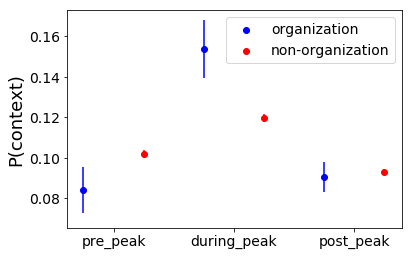

In [139]:
## plot
X = np.arange(len(peak_time_vars))
X_offset = 0.25
org_context_means_mean = [m.mean() for m in org_context_means]
non_org_context_means_mean = [m.mean() for m in non_org_context_means]
org_context_means_err = [m.std() / len(m)**.5 for m in org_context_means]
non_org_context_means_err = [m.std() / len(m)**.5 for m in non_org_context_means]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.scatter(X - X_offset, org_context_means_mean, color='b', label='organization')
ax.scatter(X + X_offset, non_org_context_means_mean, color='r', label='non-organization')
ax.errorbar(X - X_offset, org_context_means_mean, yerr=org_context_means_err, color='b', linestyle='none')
ax.errorbar(X + X_offset, non_org_context_means_mean, yerr=non_org_context_means_err, color='r', linestyle='none')
plt.legend(loc='upper right', fontsize=14)
ax.set_xticks(X)
ax.set_xticklabels(peak_time_vars)
ax.set_ylabel('P(context)', fontsize=18)
plt.show()

OK! No consistent differences, except for `during_peak` with ORG using more context as expected.

Let's restrict the analysis to authors who have at least one example of context.

In [140]:
from scipy.stats import ttest_ind, mannwhitneyu
org_context_means = []
non_org_context_means = []
for peak_time_var_i in peak_time_vars:
    org_clean_context_data_i = org_clean_context_data[org_clean_context_data.loc[:, peak_time_var_i]==1]
    non_org_clean_context_data_i = non_org_clean_context_data[non_org_clean_context_data.loc[:, peak_time_var_i]==1]
    org_context_means_i = compute_context_means(org_clean_context_data_i, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
    non_org_context_means_i = compute_context_means(non_org_clean_context_data_i, author_var=author_var, NE_data_var=NE_data_var, context_var='anchor')
    org_context_means_i = org_context_means_i[org_context_means_i > 0.]
    non_org_context_means_i = non_org_context_means_i[non_org_context_means_i > 0.]
    # test significance
#     test_stat, p_val = ttest_ind(org_context_means_i, non_org_context_means_i)
    test_stat, p_val = mannwhitneyu(org_context_means_i, non_org_context_means_i)
    print('time=%s'%(peak_time_var_i))
    print('org context use: %.3f +/- %.3f'%(org_context_means_i.mean(), org_context_means_i.std() / len(org_context_means_i)**.5))
    print('non-org context use: %.3f +/- %.3f'%(non_org_context_means_i.mean(), non_org_context_means_i.std() / len(non_org_context_means_i)**.5))
    print('test stat = %.3f (p=%3E)'%(test_stat, p_val))
    org_context_means.append(org_context_means_i)
    non_org_context_means.append(non_org_context_means_i)

time=pre_peak
org context use: 0.673 +/- 0.045
non-org context use: 0.805 +/- 0.006
test stat = 66788.500 (p=2.822645E-04)
time=during_peak
org context use: 0.698 +/- 0.031
non-org context use: 0.771 +/- 0.005
test stat = 175386.500 (p=5.090745E-03)
time=post_peak
org context use: 0.701 +/- 0.026
non-org context use: 0.797 +/- 0.005
test stat = 274249.000 (p=2.763172E-05)


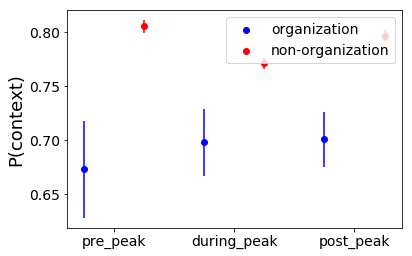

In [141]:
## plot
X = np.arange(len(peak_time_vars))
X_offset = 0.25
org_context_means_mean = [m.mean() for m in org_context_means]
non_org_context_means_mean = [m.mean() for m in non_org_context_means]
org_context_means_err = [m.std() / len(m)**.5 for m in org_context_means]
non_org_context_means_err = [m.std() / len(m)**.5 for m in non_org_context_means]
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.scatter(X - X_offset, org_context_means_mean, color='b', label='organization')
ax.scatter(X + X_offset, non_org_context_means_mean, color='r', label='non-organization')
ax.errorbar(X - X_offset, org_context_means_mean, yerr=org_context_means_err, color='b', linestyle='none')
ax.errorbar(X + X_offset, non_org_context_means_mean, yerr=non_org_context_means_err, color='r', linestyle='none')
plt.legend(loc='upper right', fontsize=14)
ax.set_xticks(X)
ax.set_xticklabels(peak_time_vars)
ax.set_ylabel('P(context)', fontsize=18)
plt.show()

Now we see the opposite effect of what is expected! Organizations use consistently less context than individuals.

Let's compare the (`post_peak_only`, `post_peak_shared`) $\times$ (`organization`, `non-organization`) combinations to determine if the overall context decrease in `post_peak` is due partly to the higher proportion of non-organizations.